In [14]:
import os
import numpy as np
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
import kcu as utils
import time
import pandas as pd
from tpot import TPOTClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE
import seaborn as sns
from kcu import capsules
import torch.optim as optim
from tqdm import tqdm
import os
import gzip
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


""" SETUP """
dry_run = True
cwdir = os.getcwd()

train_X, train_Y = load_mnist(cwdir + '/../../data/fashion', kind='train')
test_X, test_Y = load_mnist(cwdir + '/../../data/fashion', kind='t10k')

# Split train set into train and validation
train_inds, val_inds = sklearn.model_selection.train_test_split(
    np.arange(len(train_Y)), test_size=0.2
)
train_X, val_X = train_X[train_inds], train_X[val_inds]
train_Y, val_Y = train_Y[train_inds], train_Y[val_inds]

if dry_run:
    train_X, train_Y = train_X[:1024], train_Y[:1024]

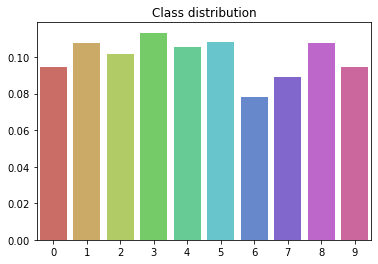

In [15]:
""" DATA EXPLORATION """
# Visualize class distribution
utils.visualization.show_class_distribution(train_Y)

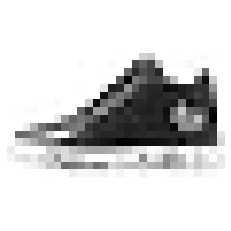

In [16]:
# As we know this is 2D image data, visualize some samples:
plt.imshow(train_X[0].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

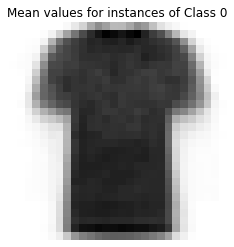

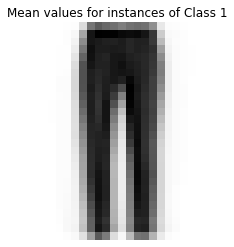

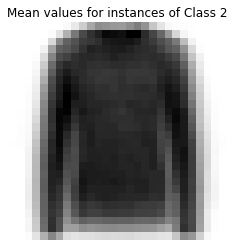

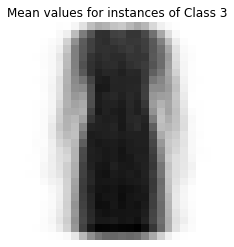

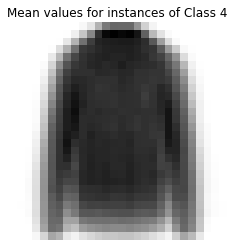

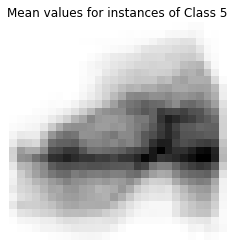

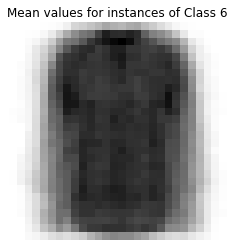

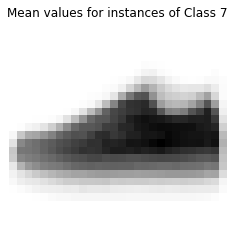

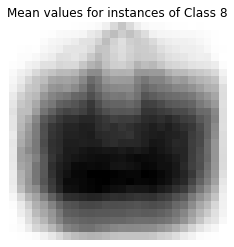

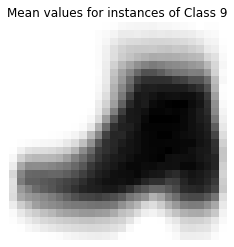

In [17]:
# Show an average of multiple instances from same class (class 1)
for i in range(10):
    inds = np.where(train_Y == i)
    acc = np.mean(train_X[inds], axis=0)
    plt.imshow(acc.reshape(28, 28), cmap="binary")
    plt.title("Mean values for instances of Class " + str(i))
    plt.axis("off")
    plt.show()

In [ ]:
# Correlation analysis: for each class, lets identify important pixels first:
for i in range(10):
    new_Y = train_Y == i
    corr_coeff = pd.DataFrame(np.hstack([train_X, np.expand_dims(new_Y, 1)])).corr()[-1:].to_numpy()[0, :-1]
    plt.imshow(corr_coeff.reshape(28, 28), cmap="PiYG")
    plt.title("Correlations of pixels with target class " + str(i))
    plt.axis("off")
    plt.show()

In [ ]:
# Lets do PCA: identifying a good linear combination of features that maximize the total variance
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(train_X)
plt.scatter(view[:,0], view[:,1], c=train_Y, alpha=0.5, cmap='Set1')
plt.axis("off")
plt.title("PCA scatter plot")
plt.show()

In [ ]:
# Lets have a look at what features/pixels were used the most by our two PCA components:
for i in [0,1]:
    plt.imshow(pca.components_[i].reshape(28,28), cmap="PiYG")
    plt.title("PCA, linear combination for Component " + str(i))
    plt.axis("off")
    plt.show()

# There are a lot of pixels with no to only a bit of weight, so we could do feature selection and simply neglect pixels
# e.g. in the corners of the images

In [ ]:
# Next, we visualize the t-SNE embedding. The desirable outcome here would be to have compact non-overlapping
# clusters of classes. This plot might already foreshadow - to some extent - how complicated the classification
# task will be
view = TSNE(n_components=2, random_state=0).fit_transform(train_X)
#plt.figure(figsize=(20,10))
plt.scatter(view[:,0], view[:,1], c=train_Y, alpha=0.5, cmap="Set1")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("t-SNE embedding")
plt.show()

In [ ]:
""" MAIN CLASSIFICATION PIPELINES """

train_X, train_Y = load_mnist(cwdir + '/../../data/fashion', kind='train')
test_X, test_Y = load_mnist(cwdir + '/../../data/fashion', kind='t10k')

train_inds, val_inds = sklearn.model_selection.train_test_split(
    np.arange(len(train_Y)), test_size=0.2
)
train_X, val_X = train_X[train_inds], train_X[val_inds]
train_Y, val_Y = train_Y[train_inds], train_Y[val_inds]

# Try several classifiers using kFold CrossValidation
performances = utils.boilerplates.run_several_classifiers(train_X, train_Y, cv=True, use_gpu_methods=False)

# Lets report their performances
chart = sns.boxplot(x="method", y="accuracy", data=performances)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Accuracy of various methods using 5-fold CV")
plt.tight_layout()
plt.show()

In [ ]:
# Also, its interesting to see how well the classifiers do with less data
all_perfs = pd.DataFrame(columns=["method", "balanced_accuracy", "num_samples"])
possible_samples = [128, 256, 512, 1024]
for samples in possible_samples:
    performances = utils.boilerplates.run_several_classifiers(train_X[:samples], train_Y[:samples], cv=True)
    performances["num_samples"] = samples
    all_perfs = all_perfs.append(performances)

chart = sns.lineplot(x="num_samples", y="accuracy", hue="method", data=all_perfs)
#chart.set_xticklabels(possible_samples)
chart.set_xticks(possible_samples)
chart.set_xticklabels(possible_samples)
plt.title("Effect of train set on accuracy of various methods")
plt.tight_layout()
plt.show()

In [ ]:
# Lets train an MLP (as they scale better than SVMs with the amount of training data)
clf = MLPClassifier()
clf.fit(train_X, train_Y)
pred = clf.predict(val_X)
score = sklearn.metrics.accuracy_score(val_Y, pred)
print("MLP Val accuracy: " + str(score))

# Plot confusion matrix of best classifier
sklearn.metrics.plot_confusion_matrix(clf,
                      val_X,
                      val_Y,
                      cmap="Reds")
plt.title("MLP confusion matrix on validation data")
plt.show()

In [ ]:
# Lets leverage the local spatial relations of the input data and use a 2D CNN
train_dataset = utils.dataset.MNISTDataset(train_X, train_Y)
val_dataset = utils.dataset.MNISTDataset(val_X, val_Y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = utils.models.MNIST_CNN_01().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
utils.boilerplates.train_classifier(
    cnn, optimizer, train_loader, device, 10, nn.CrossEntropyLoss(), val_loader, show_plot=True
)

In [ ]:
# We could do some hyperparameter tuning now by doing GridSearch, however I rather want to check out
# one particular Neural Network that I worked with during my PhD: Capsule Networks
capsule_net = capsules.CapsuleNetwork().to(device)
criterion = capsules.CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

def train(capsule_net, criterion, optimizer, n_epochs=10, print_every=300):
    losses = []
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        capsule_net.train()
        for batch_i, (images, target) in tqdm(enumerate(train_loader)):
            target = torch.eye(10).index_select(dim=0, index=target)
            images, target = images.to(device), target.to(device)
            optimizer.zero_grad()
            caps_output, reconstructions, y = capsule_net(images)
            loss = criterion(caps_output, target, images, reconstructions)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0
        if epoch % 1 == 0:
            out = []
            gt = []
            capsule_net.eval()
            for image, target in tqdm(val_loader):
                image = image.to(device)
                caps_out, reconstructed, y = capsule_net(image)
                _, pred = torch.max(y.data.cpu(), 1)
                out.extend(pred.numpy().tolist())
                gt.extend(target.numpy().tolist())

            print("Test Accuracy:", sklearn.metrics.accuracy_score(gt, out))

    return losses

losses = train(capsule_net, criterion, optimizer, n_epochs=10)